In [1]:
import os
from distutils.dir_util import copy_tree
import itertools
import scipy
from scipy import stats
import dask.dataframe as dd
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import time, pytz
from datetime import datetime
from matplotlib.ticker import MultipleLocator, FixedLocator, LogLocator, NullFormatter, ScalarFormatter

In [2]:
store_location = "./SurfCoefficients50days/"

combination_tuples_pearson = dict()
combination_tuples_spearman = dict()
combination_tuples_kendall = dict()

In [3]:
# WARNING: LOADING ALL RAW DATA TAKES A LONG TIME, USE THE DF CELL AS THAT IS PROCESSED AND STORED IN PARQUET IF AVAILABLE.
folders = next(os.walk(store_location))[1]

for folder in folders:
    start_date = folder.split("_")[0]
    
    for combination_file in next(os.walk(os.path.join(store_location, folder)))[2]:
        with open(os.path.join(store_location, folder, combination_file)) as coef_file:
            pc, sc, kc = coef_file.readline().split("|")
            pv_pc, pv_sc, pv_kc = coef_file.readline().split("|")
            combination_tuples_pearson.setdefault(combination_file, []).append((pc, start_date, pv_pc))
            combination_tuples_spearman.setdefault(combination_file, []).append((sc, start_date, pv_sc))
            combination_tuples_kendall.setdefault(combination_file, []).append((kc, start_date, pv_kc))

In [204]:
threshold = 0.7

for combination, values in combination_tuples_pearson.items():
    num_values_above_threshold = sum([1 if abs(float(v[0])) >= threshold else 0 for v in values])
    if num_values_above_threshold == len(next(os.walk(store_location))[1]):
        print(combination)


node_netstat_TcpExt_TCPFastRetrans+node_netstat_TcpExt_TCPAutoCorking_correlations.csv 50
node_memory_Slab+node_memory_Active_file_correlations.csv 50
nvidia_gpu_fanspeed_percent+node_memory_MemFree_correlations.csv 50
node_memory_Buffers+node_sockstat_sockets_used_correlations.csv 50


In [7]:
# Execute this cell to generate the plots
cache_location = "./cache/correlation_coefficients_50_separate_days.parquet"
if not os.path.exists(cache_location):
    tuple_list = [val for i in combination_tuples_spearman.keys() for val in combination_tuples_spearman[i]]
    df = pd.DataFrame(tuple_list, columns=['coef', 'start_date', 'pval'])
    df = df.replace("nan", np.nan).dropna().reset_index(drop=True)
    df['start_date'] = pd.to_datetime(df['start_date'], unit='s')
    df['coef'] = df['coef'].astype(np.float)
    df.to_parquet(cache_location, engine='pyarrow')
else:
    df = pd.read_parquet(cache_location, engine='pyarrow')

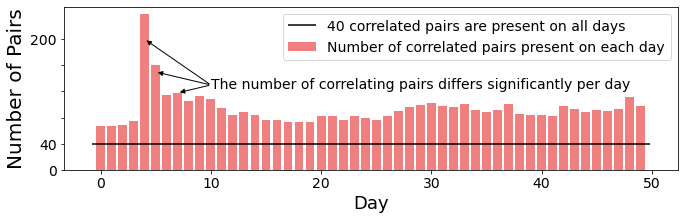

In [59]:
fig, ax = plt.subplots(figsize=(11, 3))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_xlabel("Day", fontsize=18)
ax.set_ylabel("Number of Pairs", fontsize=20)

# These two must match in size for the zip() function later
thresholds = [0.9,
#               0.7,
#               0.5,
             ]
colors = ["lightcoral", "steelblue", "yellowgreen"]
linestyles = ['solid', 'dashed', 'dotted']

bottom = None
for threshold, color, linestyle in zip(thresholds, colors, linestyles):
    count_df = df[df['coef'].abs() >= threshold].groupby('start_date').count().rename(columns={'coef': 'count'})
    data = count_df.copy()
    if bottom is not None:
        data['count'] -= bottom['count']  # As we expect more matches for a lower threshold, subtract the previous one to get the correct stack
    
    ax.bar(x=range(len(data)), height=data['count'], bottom=bottom['count'] if bottom is not None else 0, label=f"Number of correlated pairs present on each day", color=color)
    bottom = count_df
    
    num_coef_corr_all_days = 0
    for combination, values in combination_tuples_spearman.items():
        num_values_above_threshold = sum([1 if abs(float(v[0])) >= threshold else 0 for v in values])
        if num_values_above_threshold == len(next(os.walk(store_location))[1]):
            num_coef_corr_all_days += 1
    
    ax.hlines(num_coef_corr_all_days, xmin=-.8, xmax=len(data) - .2, color="black", linestyle=linestyle, label=f"{num_coef_corr_all_days} correlated pairs are present on all days")

def get_converted_xticks(ax):
    """
    :param ax:
    :return list of day and month strings
    """
    # return [pd.to_datetime(start + tick, unit='s').date().strftime("%d\n%b") for tick in ax.get_xticks()]
    return [int((tick) / 3600) for tick in ax.get_xticks()]  # Get the hour number

ax.legend(prop={"size": 14})

# you MUST use xycoords = data with this function
def my_annotate(ax, s, xy_arr=[], *args, **kwargs):  # modified from https://stackoverflow.com/a/14545981
    ans = []
    kwargs_copy = kwargs.copy()
    kwargs_copy.pop('arrowprops', None)
    an = ax.annotate(s, xy_arr[0], *args, **kwargs_copy)
    ans.append(an)
    d = {}
    xytext = kwargs['xytext']
    if 'arrowprops' in kwargs:
        d['arrowprops'] = kwargs['arrowprops']
    if 'ha' in kwargs:
        d['ha'] = kwargs['ha']
    if 'va' in kwargs:
        d['va'] = kwargs['va']
    for xy in xy_arr[0:]:
        # Hack to make the arrows start at the same position
        an = ax.annotate('', xy, alpha=0.0, xytext=xytext, xycoords='data', **d)
        ans.append(an)
    return ans

my_annotate(ax,
            s='The number of correlating pairs differs significantly per day',
            xy_arr=[[4, 200], [5, 150], [7, 118]],
            xytext=(10, 130), xycoords='data', # xytext based on the first point
            ha='left', va='center', 
            fontsize=14,
            arrowprops=dict(arrowstyle="-|>",
                            connectionstyle="arc",
                            color="black")
           )
ax.set_yticks( [0,40,80,120,160,200])
ax.set_yticklabels(['0', '40', '', '', '', '200'])

date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig.savefig(f"spearman_correlations_50_days_{date_time}.pdf", bbox_inches = "tight")
# fig.savefig(f"spearman_correlations_50_days_{date_time}.png", bbox_inches = "tight")

In [44]:
threshold = 0.8

unique_pairs = set()
for combination, values in combination_tuples_spearman.items():
    num_values_above_threshold = sum([1 if abs(float(v[0])) >= threshold else 0 for v in values])
    if num_values_above_threshold > 0:
        pair = combination.replace(".csv", "").split("+")
        unique_pairs.add((pair[0], pair[1]))


with open(f'./cache/all_pairs_above_{threshold}_spearman.csv', 'w') as outfile:
    for pair in unique_pairs:
        outfile.write(f'{pair[0]}, {pair[1]}\n')

In [4]:
threshold = 0.9
unique_pairs = set()

for combination, values in combination_tuples_spearman.items():
    num_values_above_threshold = sum([1 if abs(float(v[0])) >= threshold else 0 for v in values])
    if num_values_above_threshold == len(next(os.walk(store_location))[1]):
        pair = combination.replace(".csv", "").split("+")
        unique_pairs.add((pair[0], pair[1]))


with open(f'./cache/all_persistent_pairs_above_equal_{threshold}_spearman.csv', 'w') as outfile:
    for pair in unique_pairs:
        outfile.write(f'{pair[0]}, {pair[1]}\n')



In [5]:
threshold = 0.9
unique_pairs = set()

for combination, values in combination_tuples_spearman.items():
    num_values_above_threshold = sum([1 if abs(float(v[0])) >= threshold else 0 for v in values])
    if num_values_above_threshold >= 0:
        pair = combination.replace(".csv", "").split("+")
        unique_pairs.add((pair[0], pair[1]))


with open(f'./cache/all_pairs_above_equal_{threshold}_spearman.csv', 'w') as outfile:
    for pair in unique_pairs:
        outfile.write(f'{pair[0]}, {pair[1]}\n')

